In [1]:
import pandas as pd
import string
from random import random
import re
from collections import Counter
from bs4 import BeautifulSoup
import json
from sklearn.utils import class_weight
import scipy as np
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy

np.random.seed(101)

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [3]:
data = pd.read_csv("./Reviews.csv").fillna("")

In [4]:
print(data.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [5]:
imp_cols = set(data.columns)-{'Id','ProductId'}
print ('Number of duplicates:',data.duplicated(subset=imp_cols).sum())
data = data.drop_duplicates(subset=imp_cols)
print("Size of data : {}".format(data.shape))

Number of duplicates: 172145
Size of data : (396309, 10)


In [6]:
full_text = []
for s, t in zip(list(data["Summary"]), list(data["Text"])):
    temp = BeautifulSoup("{} {}".format(s,t).lower(), "lxml").getText()
    for punctuation in string.punctuation:
        if "\'" != punctuation:
            temp = temp.replace(punctuation, " {} ".format(punctuation))
    full_text.append(" ".join(temp.split()))   

In [7]:
full_text[0]

'good quality dog food i have bought several of the vitality canned dog food products and have found them all to be of good quality . the product looks more like a stew than a processed meat and it smells better . my labrador is finicky and she appreciates this product better than most .'

In [8]:
vocab = list(Counter(" ".join(full_text).split()).items())

vocab = sorted(vocab, reverse=True, key=lambda x:x[1])

In [9]:
top_words = 5000
req_vocab = vocab[:top_words]

In [10]:
req_vocab = {item[0]:index+1 for index, item in enumerate(req_vocab)}

In [11]:
# lets save the dictionary 
with open("required_vocabulary.txt", "w", encoding="utf8") as f:
    f.write(json.dumps(req_vocab, indent=4, sort_keys=True))

In [12]:
# change the words to integers 

full_text_int = [[req_vocab[word] for word in reveiw.split() if word in req_vocab.keys()]\
             for reveiw in full_text]

In [13]:
# sanity check, the lengths will be different because we have take taken top "top_words"
# for our model

print(full_text[0])
print(len(full_text[0]))
print(full_text_int[0])
print(len(full_text_int[0]))

good quality dog food i have bought several of the vitality canned dog food products and have found them all to be of good quality . the product looks more like a stew than a processed meat and it smells better . my labrador is finicky and she appreciates this product better than most .
287
[30, 169, 120, 65, 4, 22, 135, 341, 9, 2, 567, 120, 65, 215, 5, 22, 123, 36, 47, 7, 37, 9, 30, 169, 1, 2, 43, 675, 54, 28, 6, 2658, 62, 6, 1185, 485, 5, 8, 663, 91, 1, 15, 10, 2160, 5, 127, 11, 43, 91, 62, 156, 1]
52


In [14]:
# Here we can see that the word vitality is not found
req_vocab.get("vitality", "NOT FOUND!!")

'NOT FOUND!!'

In [15]:
# now we will make the sequence lenght equal 

default_seq_len = 600
full_text_int = sequence.pad_sequences(full_text_int, maxlen=default_seq_len)

In [16]:
print(f"Type of full_text_len : {type(full_text_int)}")
print(f"Type of full_text_len[0] : {type(full_text_int[0])}")

Type of full_text_len : <class 'numpy.ndarray'>
Type of full_text_len[0] : <class 'numpy.ndarray'>


In [17]:
# now we fill fix the labels
labels = [1 if item>3 else 0 for item in list(data["Score"].values)]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_text_int, labels, test_size=0.33, random_state=101)

In [19]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [20]:
y_train[0]

1

In [21]:
type(X_train), type(X_train[0])

(numpy.ndarray, numpy.ndarray)

In [22]:
cw = class_weight.compute_class_weight("balanced", np.array([0, 1]), y_train)

In [23]:
cw

array([2.2591121 , 0.64211715])

In [24]:
print(locals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'pd', 'string', 'random', 're', 'Counter', 'BeautifulSoup', 'json', 'class_weight', 'np', 'Sequential', 'LSTM', 'Activation', 'Dropout', 'Dense', 'Embedding', 'sequence', 'Adam', 'binary_crossentropy', 'binary_accuracy', '_i2', 'plt', 'plt_dynamic', '_i3', 'data', '_i4', '_i5', 'imp_cols', '_i6', 'full_text', 's', 't', 'temp', 'punctuation', '_i7', '_7', '_i8', 'vocab', '_i9', 'top_words', 'req_vocab', '_i10', '_i11', 'f', '_i12', 'full_text_int', '_i13', '_i14', '_14', '_i15', 'default_seq_len', '_i16', '_i17', 'labels', '_i18', 'train_test_split', 'X_train', 'X_test', 'y_train', 'y_test', '_i19', '_19', '_i20', '_20', '_i21', '_21', '_i22', 'cw', '_i23', '_23', '_i24'])


In [25]:
del s, t, temp, full_text_int, labels, data

# Model

In [26]:
embedding_size = 32

In [27]:
model = Sequential()

model.add(Embedding(top_words+1, embedding_size, input_length=default_seq_len))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(.4))

# model.add(LSTM(50))
# model.add(Dropout(.4))

model.add(Dense(1))
model.add(Activation("sigmoid"))

In [28]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 176,683
Trainable params: 176,683
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
adam = Adam(lr=3e-3)

model.compile(loss=binary_crossentropy, optimizer=adam, metrics=[binary_accuracy])

In [30]:
history = model.fit(X_train, y_train, batch_size=64, epochs=2, class_weight=cw, verbose=1, validation_data=[X_test, y_test])

Train on 265527 samples, validate on 130782 samples
Epoch 1/2
265527/265527 [==============================] - 3589s 14ms/step - loss: 0.2399 - binary_accuracy: 0.9038 - val_loss: 0.1777 - val_binary_accuracy: 0.9295
Epoch 2/2
265527/265527 [==============================] - 3578s 13ms/step - loss: 0.1694 - binary_accuracy: 0.9340 - val_loss: 0.1706 - val_binary_accuracy: 0.9322


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

In [37]:
print(f"Test loss : {score[0]}")
print(f"Test acc : {score[1]}")

Test loss : 0.1706130485179288
Test acc : 0.9322001498622497


In [32]:
history.history.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

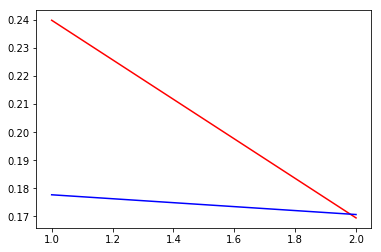

In [35]:
plt.plot(list(range(1, 3)), history.history["loss"], color="r", label="train loss")
plt.plot(list(range(1, 3)), history.history["val_loss"], color="b", label="validation loss")
plt.show()

In [36]:
history.history["val_loss"]

[0.17765866742361827, 0.17061304867334148]